In [193]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
plt.style.use('fivethirtyeight')

In [244]:
def MASE(Actual, Predicted):
    n = len(Actual)
    
    mae = mean_absolute_error(Actual, Predicted)

    # Calculate the denominator
    denominator = (1 / (n - 1)) * np.sum(np.abs(Actual[1:] - Actual[:-1]))

    # Avoid division by zero or small denominators
    if denominator > 1e-6:
        mase = mae / denominator
    else:
        mase = np.inf

    return mase

In [245]:
all_features = pd.read_csv('data/multivar_data/finaldataall.csv')
selected_features = pd.read_csv('data/multivar_data/finaldata_selectedfeatures.csv')

In [246]:
all_features = all_features.drop(['date.1', 'month_sin', 'month_cos', 'dayofweek_sin', 'dayofweek_cos', 'region_Puerto_Rico'], axis = 1)

In [247]:
all_features.columns.values.tolist()

['date',
 'location',
 'year',
 'mmwr_week',
 'covid_19_deaths',
 'distributed',
 'distributed_janssen',
 'distributed_moderna',
 'distributed_pfizer',
 'distributed_novavax',
 'distributed_unk_manuf',
 'dist_per_100k',
 'distributed_per_100k_5plus',
 'distributed_per_100k_12plus',
 'distributed_per_100k_18plus',
 'distributed_per_100k_65plus',
 'administered',
 'administered_5plus',
 'administered_12plus',
 'administered_18plus',
 'administered_65plus',
 'administered_janssen',
 'administered_moderna',
 'administered_pfizer',
 'administered_novavax',
 'administered_unk_manuf',
 'admin_per_100k',
 'admin_per_100k_5plus',
 'admin_per_100k_12plus',
 'admin_per_100k_18plus',
 'admin_per_100k_65plus',
 'recip_administered',
 'administered_dose1_recip',
 'administered_dose1_pop_pct',
 'administered_dose1_recip_5plus',
 'administered_dose1_recip_5plus_pop_pct',
 'administered_dose1_recip_12plus',
 'administered_dose1_recip_12plus_pop_pct',
 'administered_dose1_recip_18plus',
 'administered_d

## train test split

In [248]:
all_features = all_features.set_index('date')
all_features.index = pd.to_datetime(all_features.index)

In [249]:
split_date = '31-12-2022'

train = all_features.loc[all_features.index <= split_date].copy()
test = all_features.loc[all_features.index > split_date].copy()
print(train.shape)
print(test.shape)

(6974, 139)
(332, 139)


/Users/alissachu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:52: UserWarning: Parsing '31-12-2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  return self._cmp_method(other, operator.le)
/Users/alissachu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:56: UserWarning: Parsing '31-12-2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  return self._cmp_method(other, operator.gt)


In [250]:
train.head()

,location,year,mmwr_week,covid_19_deaths,distributed,distributed_janssen,distributed_moderna,distributed_pfizer,distributed_novavax,distributed_unk_manuf,...,deaths_1_year_lag_min,deaths_1_andhalf_year_lag_min,deaths_2_years_lag_min,dayofweek,quarter,dayofyear,dayofmonth,weekofyear,holidays_Holiday,holidays_Normal_day
date,,,,,,,,,,,,,,,,,,,,,
2020-01-04,AL,2020,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,5,1,4,4,1,0,1
2020-01-04,LA,2020,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,5,1,4,4,1,0,1
2020-01-04,VA,2020,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,5,1,4,4,1,0,1
2020-01-04,KY,2020,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,5,1,4,4,1,0,1
2020-01-04,KS,2020,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,5,1,4,4,1,0,1


In [251]:
train = train.reset_index()
test = test.reset_index()

In [252]:
X_train = train.drop(['covid_19_deaths', 'location', 'date'], axis = 1)
y_train = train[['covid_19_deaths']]

X_test = test.drop(['covid_19_deaths', 'location', 'date'], axis = 1)
y_test = test[['covid_19_deaths']]

In [269]:
reg = XGBRegressor()
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)], 
       verbose=True) # Change verbose to True if you want to see it train

[0]	validation_0-rmse:286.50199	validation_1-rmse:69.30910
[1]	validation_0-rmse:242.40940	validation_1-rmse:55.04453
[2]	validation_0-rmse:212.12693	validation_1-rmse:39.96581
[3]	validation_0-rmse:192.30032	validation_1-rmse:40.59878
[4]	validation_0-rmse:181.37539	validation_1-rmse:38.78196
[5]	validation_0-rmse:169.46689	validation_1-rmse:40.20793
[6]	validation_0-rmse:163.02815	validation_1-rmse:39.07939
[7]	validation_0-rmse:158.97926	validation_1-rmse:39.10583
[8]	validation_0-rmse:155.82656	validation_1-rmse:38.11398
[9]	validation_0-rmse:153.63287	validation_1-rmse:38.33571
[10]	validation_0-rmse:150.95362	validation_1-rmse:38.73166
[11]	validation_0-rmse:150.08658	validation_1-rmse:38.52421
[12]	validation_0-rmse:148.95862	validation_1-rmse:38.57128
[13]	validation_0-rmse:146.26093	validation_1-rmse:38.04501
[14]	validation_0-rmse:145.37090	validation_1-rmse:37.77923
[15]	validation_0-rmse:144.44847	validation_1-rmse:38.92430
[16]	validation_0-rmse:143.81171	validation_1-rmse

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [272]:
def MASE(Actual, Predicted):
    n = len(Actual)
    
    mae = mean_absolute_error(Actual, Predicted)

    # Calculate the denominator
    denominator = (1 / (n - 1)) * np.sum(np.abs(Actual.values[1:] - Actual.values[:-1]))

    # Avoid division by zero or small denominators
    if denominator > 1e-6:
        mase = mae / denominator
    else:
        mase = np.inf

    return mase

In [273]:
model_mae = mean_absolute_error(test['covid_19_deaths'], test['Prediction'])
model_mase = MASE(test['covid_19_deaths'], test['Prediction'])

print('Test MAE: ', model_mae)
print('Test MASE: ', model_mase)

Test MAE:  26.13248081092375
Test MASE:  0.42778690150424137


In [254]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 500, 1000],
    # Add other hyperparameters to tune if needed
}

# Instantiate the XGBRegressor
xgb = XGBRegressor(early_stopping_rounds = 10)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=5)

# Fit the grid search to the data
grid_search.fit(X_train, y_train, 
               eval_set=[(X_train, y_train), (X_test, y_test)], 
       verbose=True)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)


[0]	validation_0-rmse:350.99769	validation_1-rmse:91.01194
[1]	validation_0-rmse:348.82968	validation_1-rmse:90.18234
[2]	validation_0-rmse:346.68252	validation_1-rmse:89.36644
[3]	validation_0-rmse:344.54047	validation_1-rmse:88.55666
[4]	validation_0-rmse:342.45239	validation_1-rmse:87.76033
[5]	validation_0-rmse:340.38447	validation_1-rmse:86.88044
[6]	validation_0-rmse:338.32079	validation_1-rmse:86.09535
[7]	validation_0-rmse:336.31164	validation_1-rmse:85.23453
[8]	validation_0-rmse:334.29829	validation_1-rmse:84.47181
[9]	validation_0-rmse:332.33609	validation_1-rmse:83.62965
[10]	validation_0-rmse:330.39221	validation_1-rmse:82.80905
[11]	validation_0-rmse:328.47302	validation_1-rmse:81.99844
[12]	validation_0-rmse:326.57504	validation_1-rmse:81.28433
[13]	validation_0-rmse:324.68104	validation_1-rmse:80.57895
[14]	validation_0-rmse:322.81974	validation_1-rmse:79.79680
[15]	validation_0-rmse:321.00784	validation_1-rmse:79.02035
[16]	validation_0-rmse:319.21506	validation_1-rmse

[37]	validation_0-rmse:304.69015	validation_1-rmse:49.32509
[38]	validation_0-rmse:303.65300	validation_1-rmse:49.75391
[0]	validation_0-rmse:350.93815	validation_1-rmse:90.85560
[1]	validation_0-rmse:348.71215	validation_1-rmse:89.86978
[2]	validation_0-rmse:346.49764	validation_1-rmse:88.95566
[3]	validation_0-rmse:344.33266	validation_1-rmse:88.04938
[4]	validation_0-rmse:342.17390	validation_1-rmse:87.16324
[5]	validation_0-rmse:340.06534	validation_1-rmse:86.27242
[6]	validation_0-rmse:337.97922	validation_1-rmse:85.33321
[7]	validation_0-rmse:335.91711	validation_1-rmse:84.39519
[8]	validation_0-rmse:333.87021	validation_1-rmse:83.60942
[9]	validation_0-rmse:331.81482	validation_1-rmse:82.36291
[10]	validation_0-rmse:329.83027	validation_1-rmse:81.51725
[11]	validation_0-rmse:327.82765	validation_1-rmse:80.29949
[12]	validation_0-rmse:325.84302	validation_1-rmse:79.10073
[13]	validation_0-rmse:323.89033	validation_1-rmse:77.98620
[14]	validation_0-rmse:321.96434	validation_1-rmse

[35]	validation_0-rmse:286.24740	validation_1-rmse:81.26374
[36]	validation_0-rmse:284.80159	validation_1-rmse:81.11726
[37]	validation_0-rmse:283.33750	validation_1-rmse:81.03869
[38]	validation_0-rmse:281.90130	validation_1-rmse:80.93822
[39]	validation_0-rmse:280.51466	validation_1-rmse:80.80049
[40]	validation_0-rmse:279.14743	validation_1-rmse:80.72742
[41]	validation_0-rmse:277.62374	validation_1-rmse:80.50636
[42]	validation_0-rmse:276.26688	validation_1-rmse:80.20868
[43]	validation_0-rmse:274.75504	validation_1-rmse:79.98872
[44]	validation_0-rmse:273.26223	validation_1-rmse:79.73184
[45]	validation_0-rmse:271.95445	validation_1-rmse:79.66464
[46]	validation_0-rmse:270.51303	validation_1-rmse:79.56450
[47]	validation_0-rmse:269.09279	validation_1-rmse:79.46567
[48]	validation_0-rmse:267.85853	validation_1-rmse:79.38338
[49]	validation_0-rmse:266.53874	validation_1-rmse:79.19074
[50]	validation_0-rmse:265.30249	validation_1-rmse:78.95182
[51]	validation_0-rmse:263.92537	validat

[72]	validation_0-rmse:232.53929	validation_1-rmse:43.35412
[73]	validation_0-rmse:231.46280	validation_1-rmse:42.97389
[74]	validation_0-rmse:230.44845	validation_1-rmse:42.64185
[75]	validation_0-rmse:229.42677	validation_1-rmse:42.27385
[76]	validation_0-rmse:228.45115	validation_1-rmse:41.67800
[77]	validation_0-rmse:227.45632	validation_1-rmse:41.13062
[78]	validation_0-rmse:226.47452	validation_1-rmse:40.43579
[79]	validation_0-rmse:225.50853	validation_1-rmse:40.15450
[80]	validation_0-rmse:224.52875	validation_1-rmse:39.75406
[81]	validation_0-rmse:223.58685	validation_1-rmse:39.25832
[82]	validation_0-rmse:222.64302	validation_1-rmse:38.87153
[83]	validation_0-rmse:221.70217	validation_1-rmse:38.50941
[84]	validation_0-rmse:220.80932	validation_1-rmse:38.04925
[85]	validation_0-rmse:219.89527	validation_1-rmse:37.70975
[86]	validation_0-rmse:218.98854	validation_1-rmse:37.33429
[87]	validation_0-rmse:218.13389	validation_1-rmse:36.76721
[88]	validation_0-rmse:217.25894	validat

[109]	validation_0-rmse:219.52740	validation_1-rmse:23.97427
[110]	validation_0-rmse:218.96817	validation_1-rmse:23.72737
[111]	validation_0-rmse:218.41760	validation_1-rmse:23.53138
[112]	validation_0-rmse:217.83772	validation_1-rmse:23.38300
[113]	validation_0-rmse:217.26937	validation_1-rmse:23.22806
[114]	validation_0-rmse:216.74282	validation_1-rmse:23.02103
[115]	validation_0-rmse:216.19087	validation_1-rmse:22.89107
[116]	validation_0-rmse:215.64372	validation_1-rmse:22.76265
[117]	validation_0-rmse:215.13998	validation_1-rmse:22.58662
[118]	validation_0-rmse:214.64070	validation_1-rmse:22.47836
[119]	validation_0-rmse:214.15171	validation_1-rmse:22.32183
[120]	validation_0-rmse:213.63602	validation_1-rmse:22.18651
[121]	validation_0-rmse:213.16172	validation_1-rmse:22.10592
[122]	validation_0-rmse:212.68486	validation_1-rmse:21.89889
[123]	validation_0-rmse:212.22263	validation_1-rmse:21.73546
[124]	validation_0-rmse:211.74596	validation_1-rmse:21.63053
[125]	validation_0-rmse:

[67]	validation_0-rmse:247.29708	validation_1-rmse:44.40939
[68]	validation_0-rmse:246.30825	validation_1-rmse:44.01977
[69]	validation_0-rmse:245.33952	validation_1-rmse:43.67121
[70]	validation_0-rmse:244.38499	validation_1-rmse:43.26823
[71]	validation_0-rmse:243.42654	validation_1-rmse:42.89249
[72]	validation_0-rmse:242.50489	validation_1-rmse:42.48331
[73]	validation_0-rmse:241.58998	validation_1-rmse:42.12826
[74]	validation_0-rmse:240.68501	validation_1-rmse:41.78100
[75]	validation_0-rmse:239.78684	validation_1-rmse:41.42177
[76]	validation_0-rmse:238.91666	validation_1-rmse:41.05945
[77]	validation_0-rmse:238.06073	validation_1-rmse:40.59938
[78]	validation_0-rmse:237.21655	validation_1-rmse:40.27000
[79]	validation_0-rmse:236.37633	validation_1-rmse:39.94625
[80]	validation_0-rmse:235.58981	validation_1-rmse:39.55764
[81]	validation_0-rmse:234.78872	validation_1-rmse:39.22719
[82]	validation_0-rmse:233.98670	validation_1-rmse:38.89468
[83]	validation_0-rmse:233.16596	validat

[25]	validation_0-rmse:302.09116	validation_1-rmse:82.72419
[26]	validation_0-rmse:300.38570	validation_1-rmse:82.63363
[27]	validation_0-rmse:298.76896	validation_1-rmse:82.26163
[28]	validation_0-rmse:297.11383	validation_1-rmse:82.09965
[29]	validation_0-rmse:295.50762	validation_1-rmse:81.93648
[30]	validation_0-rmse:293.89311	validation_1-rmse:81.84669
[31]	validation_0-rmse:292.34356	validation_1-rmse:81.68839
[32]	validation_0-rmse:290.80415	validation_1-rmse:81.58371
[33]	validation_0-rmse:289.25399	validation_1-rmse:81.49694
[34]	validation_0-rmse:287.75732	validation_1-rmse:81.34649
[35]	validation_0-rmse:286.24740	validation_1-rmse:81.26374
[36]	validation_0-rmse:284.80159	validation_1-rmse:81.11726
[37]	validation_0-rmse:283.33750	validation_1-rmse:81.03869
[38]	validation_0-rmse:281.90130	validation_1-rmse:80.93822
[39]	validation_0-rmse:280.51466	validation_1-rmse:80.80049
[40]	validation_0-rmse:279.14743	validation_1-rmse:80.72742
[41]	validation_0-rmse:277.62374	validat

[161]	validation_0-rmse:189.91564	validation_1-rmse:61.94282
[162]	validation_0-rmse:189.64796	validation_1-rmse:61.82604
[163]	validation_0-rmse:189.31828	validation_1-rmse:61.88967
[164]	validation_0-rmse:189.01682	validation_1-rmse:61.95277
[165]	validation_0-rmse:188.73637	validation_1-rmse:61.86339
[166]	validation_0-rmse:188.46304	validation_1-rmse:61.77240
[167]	validation_0-rmse:188.19377	validation_1-rmse:61.68239
[168]	validation_0-rmse:187.93974	validation_1-rmse:61.60081
[169]	validation_0-rmse:187.59362	validation_1-rmse:61.42241
[170]	validation_0-rmse:187.33716	validation_1-rmse:61.34071
[171]	validation_0-rmse:187.08412	validation_1-rmse:61.26186
[172]	validation_0-rmse:186.74986	validation_1-rmse:61.08574
[173]	validation_0-rmse:186.53009	validation_1-rmse:61.00356
[174]	validation_0-rmse:186.28772	validation_1-rmse:60.92747
[175]	validation_0-rmse:186.03781	validation_1-rmse:60.85218
[176]	validation_0-rmse:185.82101	validation_1-rmse:60.73776
[177]	validation_0-rmse:

[98]	validation_0-rmse:209.45651	validation_1-rmse:33.32657
[99]	validation_0-rmse:208.76328	validation_1-rmse:33.15962
[100]	validation_0-rmse:208.04084	validation_1-rmse:32.85992
[101]	validation_0-rmse:207.27259	validation_1-rmse:32.67169
[102]	validation_0-rmse:206.57104	validation_1-rmse:32.40462
[103]	validation_0-rmse:205.87904	validation_1-rmse:32.07668
[104]	validation_0-rmse:205.19777	validation_1-rmse:31.85150
[105]	validation_0-rmse:204.46229	validation_1-rmse:31.61112
[106]	validation_0-rmse:203.75574	validation_1-rmse:31.16867
[107]	validation_0-rmse:203.10185	validation_1-rmse:31.00017
[108]	validation_0-rmse:202.41465	validation_1-rmse:30.61619
[109]	validation_0-rmse:201.80791	validation_1-rmse:30.49439
[110]	validation_0-rmse:201.16942	validation_1-rmse:30.27214
[111]	validation_0-rmse:200.54722	validation_1-rmse:30.17590
[112]	validation_0-rmse:199.87790	validation_1-rmse:30.06168
[113]	validation_0-rmse:199.27132	validation_1-rmse:29.80117
[114]	validation_0-rmse:19

[97]	validation_0-rmse:226.98906	validation_1-rmse:28.12121
[98]	validation_0-rmse:226.31507	validation_1-rmse:27.63707
[99]	validation_0-rmse:225.66291	validation_1-rmse:27.13535
[100]	validation_0-rmse:225.00904	validation_1-rmse:26.90735
[101]	validation_0-rmse:224.36572	validation_1-rmse:26.41569
[102]	validation_0-rmse:223.72219	validation_1-rmse:26.17772
[103]	validation_0-rmse:223.08929	validation_1-rmse:25.83204
[104]	validation_0-rmse:222.48070	validation_1-rmse:25.47854
[105]	validation_0-rmse:221.86835	validation_1-rmse:25.16171
[106]	validation_0-rmse:221.26839	validation_1-rmse:24.69713
[107]	validation_0-rmse:220.68343	validation_1-rmse:24.42059
[108]	validation_0-rmse:220.09541	validation_1-rmse:24.23238
[109]	validation_0-rmse:219.52740	validation_1-rmse:23.97427
[110]	validation_0-rmse:218.96817	validation_1-rmse:23.72737
[111]	validation_0-rmse:218.41760	validation_1-rmse:23.53138
[112]	validation_0-rmse:217.83772	validation_1-rmse:23.38300
[113]	validation_0-rmse:217

[54]	validation_0-rmse:261.37556	validation_1-rmse:49.73340
[55]	validation_0-rmse:260.24587	validation_1-rmse:49.25093
[56]	validation_0-rmse:259.05317	validation_1-rmse:48.81302
[57]	validation_0-rmse:257.89472	validation_1-rmse:48.49723
[58]	validation_0-rmse:256.81477	validation_1-rmse:47.95613
[59]	validation_0-rmse:255.68774	validation_1-rmse:47.65177
[60]	validation_0-rmse:254.64609	validation_1-rmse:47.17429
[61]	validation_0-rmse:253.50033	validation_1-rmse:46.64405
[62]	validation_0-rmse:252.41764	validation_1-rmse:46.35548
[63]	validation_0-rmse:251.35749	validation_1-rmse:45.95056
[64]	validation_0-rmse:250.29349	validation_1-rmse:45.54403
[65]	validation_0-rmse:249.24450	validation_1-rmse:45.26747
[66]	validation_0-rmse:248.28681	validation_1-rmse:44.82983
[67]	validation_0-rmse:247.29708	validation_1-rmse:44.40939
[68]	validation_0-rmse:246.30825	validation_1-rmse:44.01977
[69]	validation_0-rmse:245.33952	validation_1-rmse:43.67121
[70]	validation_0-rmse:244.38499	validat

[11]	validation_0-rmse:327.86515	validation_1-rmse:86.60089
[12]	validation_0-rmse:325.86221	validation_1-rmse:86.40727
[13]	validation_0-rmse:323.90125	validation_1-rmse:86.20154
[14]	validation_0-rmse:321.94788	validation_1-rmse:85.99711
[15]	validation_0-rmse:320.00800	validation_1-rmse:85.64062
[16]	validation_0-rmse:318.15692	validation_1-rmse:85.44581
[17]	validation_0-rmse:316.26693	validation_1-rmse:85.09909
[18]	validation_0-rmse:314.39993	validation_1-rmse:84.75799
[19]	validation_0-rmse:312.59360	validation_1-rmse:84.38220
[20]	validation_0-rmse:310.77640	validation_1-rmse:84.04945
[21]	validation_0-rmse:309.01426	validation_1-rmse:83.68784
[22]	validation_0-rmse:307.24884	validation_1-rmse:83.36229
[23]	validation_0-rmse:305.47884	validation_1-rmse:83.03470
[24]	validation_0-rmse:303.77170	validation_1-rmse:82.85495
[25]	validation_0-rmse:302.09116	validation_1-rmse:82.72419
[26]	validation_0-rmse:300.38570	validation_1-rmse:82.63363
[27]	validation_0-rmse:298.76896	validat

[147]	validation_0-rmse:194.39173	validation_1-rmse:62.76640
[148]	validation_0-rmse:194.04613	validation_1-rmse:62.65266
[149]	validation_0-rmse:193.68071	validation_1-rmse:62.71346
[150]	validation_0-rmse:193.33162	validation_1-rmse:62.51785
[151]	validation_0-rmse:192.97861	validation_1-rmse:62.57627
[152]	validation_0-rmse:192.63568	validation_1-rmse:62.47053
[153]	validation_0-rmse:192.30666	validation_1-rmse:62.32619
[154]	validation_0-rmse:191.99052	validation_1-rmse:62.22168
[155]	validation_0-rmse:191.70553	validation_1-rmse:62.27272
[156]	validation_0-rmse:191.38461	validation_1-rmse:62.16740
[157]	validation_0-rmse:191.09554	validation_1-rmse:62.04463
[158]	validation_0-rmse:190.77475	validation_1-rmse:62.11053
[159]	validation_0-rmse:190.45607	validation_1-rmse:62.17157
[160]	validation_0-rmse:190.18235	validation_1-rmse:62.07655
[161]	validation_0-rmse:189.91564	validation_1-rmse:61.94282
[162]	validation_0-rmse:189.64796	validation_1-rmse:61.82604
[163]	validation_0-rmse:

[75]	validation_0-rmse:229.42677	validation_1-rmse:42.27385
[76]	validation_0-rmse:228.45115	validation_1-rmse:41.67800
[77]	validation_0-rmse:227.45632	validation_1-rmse:41.13062
[78]	validation_0-rmse:226.47452	validation_1-rmse:40.43579
[79]	validation_0-rmse:225.50853	validation_1-rmse:40.15450
[80]	validation_0-rmse:224.52875	validation_1-rmse:39.75406
[81]	validation_0-rmse:223.58685	validation_1-rmse:39.25832
[82]	validation_0-rmse:222.64302	validation_1-rmse:38.87153
[83]	validation_0-rmse:221.70217	validation_1-rmse:38.50941
[84]	validation_0-rmse:220.80932	validation_1-rmse:38.04925
[85]	validation_0-rmse:219.89527	validation_1-rmse:37.70975
[86]	validation_0-rmse:218.98854	validation_1-rmse:37.33429
[87]	validation_0-rmse:218.13389	validation_1-rmse:36.76721
[88]	validation_0-rmse:217.25894	validation_1-rmse:36.41238
[89]	validation_0-rmse:216.45548	validation_1-rmse:36.19619
[90]	validation_0-rmse:215.62225	validation_1-rmse:35.60605
[91]	validation_0-rmse:214.84218	validat

[74]	validation_0-rmse:244.68456	validation_1-rmse:38.71587
[75]	validation_0-rmse:243.79559	validation_1-rmse:38.40296
[76]	validation_0-rmse:242.94982	validation_1-rmse:37.68759
[77]	validation_0-rmse:242.10389	validation_1-rmse:37.31608
[78]	validation_0-rmse:241.27728	validation_1-rmse:36.62547
[79]	validation_0-rmse:240.43786	validation_1-rmse:36.28057
[80]	validation_0-rmse:239.62995	validation_1-rmse:35.88827
[81]	validation_0-rmse:238.82286	validation_1-rmse:35.47554
[82]	validation_0-rmse:238.05894	validation_1-rmse:35.09650
[83]	validation_0-rmse:237.28433	validation_1-rmse:34.46061
[84]	validation_0-rmse:236.47363	validation_1-rmse:34.09691
[85]	validation_0-rmse:235.67602	validation_1-rmse:33.74955
[86]	validation_0-rmse:234.89641	validation_1-rmse:33.45115
[87]	validation_0-rmse:234.13235	validation_1-rmse:33.10804
[88]	validation_0-rmse:233.35741	validation_1-rmse:32.76854
[89]	validation_0-rmse:232.60412	validation_1-rmse:32.44848
[90]	validation_0-rmse:231.86593	validat

[30]	validation_0-rmse:293.98421	validation_1-rmse:63.51947
[31]	validation_0-rmse:292.46240	validation_1-rmse:62.66029
[32]	validation_0-rmse:290.88517	validation_1-rmse:62.05482
[33]	validation_0-rmse:289.32430	validation_1-rmse:61.50852
[34]	validation_0-rmse:287.77542	validation_1-rmse:60.96968
[35]	validation_0-rmse:286.33059	validation_1-rmse:60.41677
[36]	validation_0-rmse:284.82990	validation_1-rmse:59.89016
[37]	validation_0-rmse:283.35230	validation_1-rmse:59.29375
[38]	validation_0-rmse:281.89246	validation_1-rmse:58.75879
[39]	validation_0-rmse:280.50803	validation_1-rmse:58.22776
[40]	validation_0-rmse:279.08661	validation_1-rmse:57.62237
[41]	validation_0-rmse:277.68440	validation_1-rmse:57.02621
[42]	validation_0-rmse:276.30048	validation_1-rmse:56.40273
[43]	validation_0-rmse:274.99410	validation_1-rmse:55.90539
[44]	validation_0-rmse:273.68128	validation_1-rmse:55.27965
[45]	validation_0-rmse:272.38002	validation_1-rmse:54.55159
[46]	validation_0-rmse:271.10743	validat

[166]	validation_0-rmse:194.19038	validation_1-rmse:25.50495
[167]	validation_0-rmse:193.95938	validation_1-rmse:25.45240
[168]	validation_0-rmse:193.71813	validation_1-rmse:25.40229
[169]	validation_0-rmse:193.45633	validation_1-rmse:25.50523
[170]	validation_0-rmse:193.24859	validation_1-rmse:25.47534
[171]	validation_0-rmse:193.00045	validation_1-rmse:25.48293
[172]	validation_0-rmse:192.80283	validation_1-rmse:25.45762
[173]	validation_0-rmse:192.56242	validation_1-rmse:25.48830
[174]	validation_0-rmse:192.37144	validation_1-rmse:25.46801
[175]	validation_0-rmse:192.13155	validation_1-rmse:25.59110
[176]	validation_0-rmse:191.94588	validation_1-rmse:25.56617
[177]	validation_0-rmse:191.76385	validation_1-rmse:25.54554
[178]	validation_0-rmse:191.53671	validation_1-rmse:25.57727
[0]	validation_0-rmse:350.94704	validation_1-rmse:91.37887
[1]	validation_0-rmse:348.72986	validation_1-rmse:90.91003
[2]	validation_0-rmse:346.53993	validation_1-rmse:90.45965
[3]	validation_0-rmse:344.3787

[124]	validation_0-rmse:204.24924	validation_1-rmse:64.01195
[125]	validation_0-rmse:203.77666	validation_1-rmse:63.75377
[126]	validation_0-rmse:203.30143	validation_1-rmse:63.81795
[127]	validation_0-rmse:202.81096	validation_1-rmse:63.62326
[128]	validation_0-rmse:202.32932	validation_1-rmse:63.60151
[129]	validation_0-rmse:201.86800	validation_1-rmse:63.49185
[130]	validation_0-rmse:201.41720	validation_1-rmse:63.24481
[131]	validation_0-rmse:201.02280	validation_1-rmse:63.47397
[132]	validation_0-rmse:200.49766	validation_1-rmse:63.42042
[133]	validation_0-rmse:200.06835	validation_1-rmse:63.27946
[134]	validation_0-rmse:199.61494	validation_1-rmse:63.33980
[135]	validation_0-rmse:199.18489	validation_1-rmse:63.37637
[136]	validation_0-rmse:198.72513	validation_1-rmse:63.43591
[137]	validation_0-rmse:198.30177	validation_1-rmse:63.41785
[138]	validation_0-rmse:197.90553	validation_1-rmse:63.28448
[139]	validation_0-rmse:197.49249	validation_1-rmse:63.34453
[140]	validation_0-rmse:

[51]	validation_0-rmse:257.10022	validation_1-rmse:54.39366
[52]	validation_0-rmse:255.77547	validation_1-rmse:53.86014
[53]	validation_0-rmse:254.47407	validation_1-rmse:53.35738
[54]	validation_0-rmse:253.20989	validation_1-rmse:52.56069
[55]	validation_0-rmse:251.93954	validation_1-rmse:52.11328
[56]	validation_0-rmse:250.67838	validation_1-rmse:51.57283
[57]	validation_0-rmse:249.46112	validation_1-rmse:50.81431
[58]	validation_0-rmse:248.23428	validation_1-rmse:50.28386
[59]	validation_0-rmse:247.01440	validation_1-rmse:49.88659
[60]	validation_0-rmse:245.85594	validation_1-rmse:49.30286
[61]	validation_0-rmse:244.63338	validation_1-rmse:48.93559
[62]	validation_0-rmse:243.45413	validation_1-rmse:48.57788
[63]	validation_0-rmse:242.34552	validation_1-rmse:47.88734
[64]	validation_0-rmse:241.25107	validation_1-rmse:47.21556
[65]	validation_0-rmse:240.09077	validation_1-rmse:46.80957
[66]	validation_0-rmse:238.94652	validation_1-rmse:46.49257
[67]	validation_0-rmse:237.81469	validat

[49]	validation_0-rmse:270.43775	validation_1-rmse:52.13108
[50]	validation_0-rmse:269.24460	validation_1-rmse:51.65825
[51]	validation_0-rmse:268.04341	validation_1-rmse:50.99917
[52]	validation_0-rmse:266.87874	validation_1-rmse:50.40886
[53]	validation_0-rmse:265.72278	validation_1-rmse:49.96232
[54]	validation_0-rmse:264.58754	validation_1-rmse:49.49244
[55]	validation_0-rmse:263.46835	validation_1-rmse:48.93277
[56]	validation_0-rmse:262.33613	validation_1-rmse:48.31353
[57]	validation_0-rmse:261.26937	validation_1-rmse:47.43409
[58]	validation_0-rmse:260.18534	validation_1-rmse:47.01933
[59]	validation_0-rmse:259.10152	validation_1-rmse:46.60533
[60]	validation_0-rmse:258.02742	validation_1-rmse:46.04495
[61]	validation_0-rmse:257.01357	validation_1-rmse:45.52467
[62]	validation_0-rmse:256.01098	validation_1-rmse:44.67611
[63]	validation_0-rmse:254.99437	validation_1-rmse:44.25701
[64]	validation_0-rmse:253.97774	validation_1-rmse:43.86719
[65]	validation_0-rmse:253.01293	validat

[6]	validation_0-rmse:337.97922	validation_1-rmse:85.33321
[7]	validation_0-rmse:335.91711	validation_1-rmse:84.39519
[8]	validation_0-rmse:333.87021	validation_1-rmse:83.60942
[9]	validation_0-rmse:331.81482	validation_1-rmse:82.36291
[10]	validation_0-rmse:329.83027	validation_1-rmse:81.51725
[11]	validation_0-rmse:327.82765	validation_1-rmse:80.29949
[12]	validation_0-rmse:325.84302	validation_1-rmse:79.10073
[13]	validation_0-rmse:323.89033	validation_1-rmse:77.98620
[14]	validation_0-rmse:321.96434	validation_1-rmse:76.81055
[15]	validation_0-rmse:320.01445	validation_1-rmse:76.02930
[16]	validation_0-rmse:318.13420	validation_1-rmse:74.88646
[17]	validation_0-rmse:316.27539	validation_1-rmse:73.75842
[18]	validation_0-rmse:314.40929	validation_1-rmse:72.68763
[19]	validation_0-rmse:312.60001	validation_1-rmse:71.60852
[20]	validation_0-rmse:310.77272	validation_1-rmse:70.92809
[21]	validation_0-rmse:308.99260	validation_1-rmse:70.15907
[22]	validation_0-rmse:307.25274	validation_

[142]	validation_0-rmse:201.21365	validation_1-rmse:25.98719
[143]	validation_0-rmse:200.88007	validation_1-rmse:25.94958
[144]	validation_0-rmse:200.55012	validation_1-rmse:25.98669
[145]	validation_0-rmse:200.23023	validation_1-rmse:25.88275
[146]	validation_0-rmse:199.91270	validation_1-rmse:25.79916
[147]	validation_0-rmse:199.59948	validation_1-rmse:25.77423
[148]	validation_0-rmse:199.25514	validation_1-rmse:25.75317
[149]	validation_0-rmse:198.96171	validation_1-rmse:25.81439
[150]	validation_0-rmse:198.62683	validation_1-rmse:25.79936
[151]	validation_0-rmse:198.34857	validation_1-rmse:25.78173
[152]	validation_0-rmse:198.05566	validation_1-rmse:25.67639
[153]	validation_0-rmse:197.73350	validation_1-rmse:25.66956
[154]	validation_0-rmse:197.46764	validation_1-rmse:25.67577
[155]	validation_0-rmse:197.15307	validation_1-rmse:25.67524
[156]	validation_0-rmse:196.83605	validation_1-rmse:25.66524
[157]	validation_0-rmse:196.56496	validation_1-rmse:25.60079
[158]	validation_0-rmse:

[100]	validation_0-rmse:218.85083	validation_1-rmse:68.00161
[101]	validation_0-rmse:218.06522	validation_1-rmse:67.76885
[102]	validation_0-rmse:217.33515	validation_1-rmse:67.53830
[103]	validation_0-rmse:216.68953	validation_1-rmse:67.40440
[104]	validation_0-rmse:216.04875	validation_1-rmse:67.27222
[105]	validation_0-rmse:215.30524	validation_1-rmse:67.04847
[106]	validation_0-rmse:214.55831	validation_1-rmse:67.03667
[107]	validation_0-rmse:213.84212	validation_1-rmse:66.81648
[108]	validation_0-rmse:213.23362	validation_1-rmse:66.68937
[109]	validation_0-rmse:212.60653	validation_1-rmse:66.51564
[110]	validation_0-rmse:211.98119	validation_1-rmse:66.47981
[111]	validation_0-rmse:211.39865	validation_1-rmse:66.35887
[112]	validation_0-rmse:210.82774	validation_1-rmse:66.20558
[113]	validation_0-rmse:210.18899	validation_1-rmse:65.88095
[114]	validation_0-rmse:209.61871	validation_1-rmse:65.60539
[115]	validation_0-rmse:209.00596	validation_1-rmse:65.28801
[116]	validation_0-rmse:

[26]	validation_0-rmse:295.97044	validation_1-rmse:70.73401
[27]	validation_0-rmse:294.18537	validation_1-rmse:69.90972
[28]	validation_0-rmse:292.42387	validation_1-rmse:69.39415
[29]	validation_0-rmse:290.66029	validation_1-rmse:68.70356
[30]	validation_0-rmse:288.91722	validation_1-rmse:68.01140
[31]	validation_0-rmse:287.19738	validation_1-rmse:67.32759
[32]	validation_0-rmse:285.49982	validation_1-rmse:66.67836
[33]	validation_0-rmse:283.82109	validation_1-rmse:66.02899
[34]	validation_0-rmse:282.16668	validation_1-rmse:65.36959
[35]	validation_0-rmse:280.53248	validation_1-rmse:64.85522
[36]	validation_0-rmse:278.92404	validation_1-rmse:64.20967
[37]	validation_0-rmse:277.32858	validation_1-rmse:63.52945
[38]	validation_0-rmse:275.77486	validation_1-rmse:62.79251
[39]	validation_0-rmse:274.22213	validation_1-rmse:62.12773
[40]	validation_0-rmse:272.68683	validation_1-rmse:61.50951
[41]	validation_0-rmse:271.17327	validation_1-rmse:60.98846
[42]	validation_0-rmse:269.67574	validat

[25]	validation_0-rmse:208.59619	validation_1-rmse:21.58897
[26]	validation_0-rmse:206.73316	validation_1-rmse:22.07557
[27]	validation_0-rmse:204.71664	validation_1-rmse:22.90056
[28]	validation_0-rmse:202.79043	validation_1-rmse:23.23596
[29]	validation_0-rmse:201.00328	validation_1-rmse:23.76253
[30]	validation_0-rmse:199.38246	validation_1-rmse:24.49232
[31]	validation_0-rmse:197.87399	validation_1-rmse:25.54190
[32]	validation_0-rmse:196.54210	validation_1-rmse:26.59273
[33]	validation_0-rmse:195.21063	validation_1-rmse:27.44770
[34]	validation_0-rmse:193.93680	validation_1-rmse:28.31485
[0]	validation_0-rmse:345.81670	validation_1-rmse:82.89827
[1]	validation_0-rmse:338.98315	validation_1-rmse:68.22233
[2]	validation_0-rmse:331.64556	validation_1-rmse:60.12549
[3]	validation_0-rmse:325.26236	validation_1-rmse:51.05410
[4]	validation_0-rmse:318.76463	validation_1-rmse:45.74871
[5]	validation_0-rmse:313.64219	validation_1-rmse:43.77254
[6]	validation_0-rmse:308.00449	validation_1-r

[21]	validation_0-rmse:201.08708	validation_1-rmse:31.05719
[22]	validation_0-rmse:197.83045	validation_1-rmse:28.71882
[23]	validation_0-rmse:194.94183	validation_1-rmse:27.94556
[24]	validation_0-rmse:192.28078	validation_1-rmse:26.54460
[25]	validation_0-rmse:189.82788	validation_1-rmse:26.31695
[26]	validation_0-rmse:187.55298	validation_1-rmse:27.07517
[27]	validation_0-rmse:185.29741	validation_1-rmse:27.31842
[28]	validation_0-rmse:183.32402	validation_1-rmse:28.98734
[29]	validation_0-rmse:181.53152	validation_1-rmse:31.66027
[30]	validation_0-rmse:179.72183	validation_1-rmse:33.96936
[31]	validation_0-rmse:178.06041	validation_1-rmse:36.13872
[32]	validation_0-rmse:176.42272	validation_1-rmse:36.54106
[33]	validation_0-rmse:175.04592	validation_1-rmse:38.49049
[34]	validation_0-rmse:173.74446	validation_1-rmse:40.91457
[35]	validation_0-rmse:172.54870	validation_1-rmse:42.97502
[0]	validation_0-rmse:342.28871	validation_1-rmse:87.66288
[1]	validation_0-rmse:331.92154	validatio

[31]	validation_0-rmse:190.07142	validation_1-rmse:62.85718
[32]	validation_0-rmse:188.32669	validation_1-rmse:63.23776
[33]	validation_0-rmse:186.85866	validation_1-rmse:62.49736
[34]	validation_0-rmse:185.62970	validation_1-rmse:62.68826
[35]	validation_0-rmse:184.42753	validation_1-rmse:62.16506
[36]	validation_0-rmse:183.23249	validation_1-rmse:61.65013
[37]	validation_0-rmse:182.20540	validation_1-rmse:61.33902
[38]	validation_0-rmse:181.21003	validation_1-rmse:60.94751
[39]	validation_0-rmse:180.67303	validation_1-rmse:66.35666
[40]	validation_0-rmse:179.80636	validation_1-rmse:66.11771
[41]	validation_0-rmse:179.30055	validation_1-rmse:72.45697
[42]	validation_0-rmse:178.61457	validation_1-rmse:72.62925
[43]	validation_0-rmse:177.91185	validation_1-rmse:71.98788
[44]	validation_0-rmse:177.19325	validation_1-rmse:72.06432
[45]	validation_0-rmse:177.20604	validation_1-rmse:81.00346
[46]	validation_0-rmse:176.60032	validation_1-rmse:80.87546
[47]	validation_0-rmse:176.05597	validat

[36]	validation_0-rmse:190.14432	validation_1-rmse:25.95406
[37]	validation_0-rmse:189.15264	validation_1-rmse:26.23231
[38]	validation_0-rmse:188.49147	validation_1-rmse:26.55380
[39]	validation_0-rmse:187.85421	validation_1-rmse:26.79719
[40]	validation_0-rmse:187.05356	validation_1-rmse:27.03620
[41]	validation_0-rmse:186.47220	validation_1-rmse:26.92759
[42]	validation_0-rmse:185.78331	validation_1-rmse:27.29213
[0]	validation_0-rmse:342.04452	validation_1-rmse:89.49289
[1]	validation_0-rmse:331.59696	validation_1-rmse:87.34087
[2]	validation_0-rmse:321.62714	validation_1-rmse:85.29744
[3]	validation_0-rmse:312.01265	validation_1-rmse:83.57774
[4]	validation_0-rmse:303.31444	validation_1-rmse:82.65739
[5]	validation_0-rmse:294.85366	validation_1-rmse:81.08820
[6]	validation_0-rmse:286.88571	validation_1-rmse:80.71733
[7]	validation_0-rmse:279.64026	validation_1-rmse:79.98457
[8]	validation_0-rmse:272.64769	validation_1-rmse:79.64505
[9]	validation_0-rmse:265.35924	validation_1-rmse

[14]	validation_0-rmse:274.59878	validation_1-rmse:96.88718
[0]	validation_0-rmse:341.99236	validation_1-rmse:86.88987
[1]	validation_0-rmse:331.44432	validation_1-rmse:82.82416
[2]	validation_0-rmse:321.35860	validation_1-rmse:76.72856
[3]	validation_0-rmse:311.81705	validation_1-rmse:71.01540
[4]	validation_0-rmse:302.92748	validation_1-rmse:67.71829
[5]	validation_0-rmse:294.51637	validation_1-rmse:64.30657
[6]	validation_0-rmse:286.86276	validation_1-rmse:61.09169
[7]	validation_0-rmse:279.38255	validation_1-rmse:58.44600
[8]	validation_0-rmse:272.43300	validation_1-rmse:55.47312
[9]	validation_0-rmse:266.19983	validation_1-rmse:53.06874
[10]	validation_0-rmse:260.30994	validation_1-rmse:50.30725
[11]	validation_0-rmse:254.67488	validation_1-rmse:47.97357
[12]	validation_0-rmse:249.14636	validation_1-rmse:45.27707
[13]	validation_0-rmse:244.28177	validation_1-rmse:42.64566
[14]	validation_0-rmse:239.68404	validation_1-rmse:41.04241
[15]	validation_0-rmse:235.26420	validation_1-rmse

[12]	validation_0-rmse:252.87515	validation_1-rmse:43.13904
[13]	validation_0-rmse:248.04068	validation_1-rmse:40.67102
[14]	validation_0-rmse:243.64661	validation_1-rmse:37.10490
[15]	validation_0-rmse:239.23362	validation_1-rmse:34.94711
[16]	validation_0-rmse:235.33541	validation_1-rmse:33.00691
[17]	validation_0-rmse:231.46878	validation_1-rmse:31.29593
[18]	validation_0-rmse:227.90899	validation_1-rmse:28.97152
[19]	validation_0-rmse:224.55167	validation_1-rmse:26.84603
[20]	validation_0-rmse:221.36487	validation_1-rmse:25.10480
[21]	validation_0-rmse:218.46842	validation_1-rmse:23.99669
[22]	validation_0-rmse:215.72845	validation_1-rmse:22.27832
[23]	validation_0-rmse:213.22575	validation_1-rmse:21.84898
[24]	validation_0-rmse:210.93757	validation_1-rmse:21.48903
[25]	validation_0-rmse:208.59619	validation_1-rmse:21.58897
[26]	validation_0-rmse:206.73316	validation_1-rmse:22.07557
[27]	validation_0-rmse:204.71664	validation_1-rmse:22.90056
[28]	validation_0-rmse:202.79043	validat

[10]	validation_0-rmse:252.00149	validation_1-rmse:50.58206
[11]	validation_0-rmse:245.74097	validation_1-rmse:47.90720
[12]	validation_0-rmse:240.05604	validation_1-rmse:45.41286
[13]	validation_0-rmse:234.47091	validation_1-rmse:43.19356
[14]	validation_0-rmse:229.52090	validation_1-rmse:40.33395
[15]	validation_0-rmse:224.38324	validation_1-rmse:38.64159
[16]	validation_0-rmse:219.78934	validation_1-rmse:36.69907
[17]	validation_0-rmse:215.43172	validation_1-rmse:34.74576
[18]	validation_0-rmse:211.24323	validation_1-rmse:33.32975
[19]	validation_0-rmse:207.64577	validation_1-rmse:32.44736
[20]	validation_0-rmse:204.15022	validation_1-rmse:31.36285
[21]	validation_0-rmse:201.08708	validation_1-rmse:31.05719
[22]	validation_0-rmse:197.83045	validation_1-rmse:28.71882
[23]	validation_0-rmse:194.94183	validation_1-rmse:27.94556
[24]	validation_0-rmse:192.28078	validation_1-rmse:26.54460
[25]	validation_0-rmse:189.82788	validation_1-rmse:26.31695
[26]	validation_0-rmse:187.55298	validat

[6]	validation_0-rmse:246.51204	validation_1-rmse:39.73385
[7]	validation_0-rmse:237.66835	validation_1-rmse:34.99993
[8]	validation_0-rmse:230.34298	validation_1-rmse:29.12029
[9]	validation_0-rmse:223.48698	validation_1-rmse:25.17732
[10]	validation_0-rmse:217.38331	validation_1-rmse:22.90193
[11]	validation_0-rmse:212.06178	validation_1-rmse:21.51520
[12]	validation_0-rmse:207.37894	validation_1-rmse:21.17984
[13]	validation_0-rmse:203.25787	validation_1-rmse:22.03729
[14]	validation_0-rmse:200.00045	validation_1-rmse:22.37796
[15]	validation_0-rmse:196.97678	validation_1-rmse:24.27289
[16]	validation_0-rmse:193.92049	validation_1-rmse:25.54938
[17]	validation_0-rmse:191.62567	validation_1-rmse:28.68266
[18]	validation_0-rmse:189.78644	validation_1-rmse:31.50243
[19]	validation_0-rmse:188.11012	validation_1-rmse:32.51701
[20]	validation_0-rmse:186.55994	validation_1-rmse:34.08151
[21]	validation_0-rmse:185.20227	validation_1-rmse:35.37727
[0]	validation_0-rmse:338.65577	validation_1

[4]	validation_0-rmse:264.29226	validation_1-rmse:49.09546
[5]	validation_0-rmse:252.25726	validation_1-rmse:43.17636
[6]	validation_0-rmse:242.35555	validation_1-rmse:40.04342
[7]	validation_0-rmse:233.41301	validation_1-rmse:37.59197
[8]	validation_0-rmse:225.91552	validation_1-rmse:34.95716
[9]	validation_0-rmse:219.26082	validation_1-rmse:32.81518
[10]	validation_0-rmse:213.69632	validation_1-rmse:30.78753
[11]	validation_0-rmse:209.00533	validation_1-rmse:28.68758
[12]	validation_0-rmse:204.26513	validation_1-rmse:28.65667
[13]	validation_0-rmse:200.64433	validation_1-rmse:27.52132
[14]	validation_0-rmse:197.64539	validation_1-rmse:29.78950
[15]	validation_0-rmse:194.67575	validation_1-rmse:31.16531
[16]	validation_0-rmse:192.33416	validation_1-rmse:31.22759
[17]	validation_0-rmse:190.63305	validation_1-rmse:31.28109
[18]	validation_0-rmse:189.02570	validation_1-rmse:32.55199
[19]	validation_0-rmse:187.55495	validation_1-rmse:32.91277
[20]	validation_0-rmse:185.84153	validation_1-

[12]	validation_0-rmse:200.09491	validation_1-rmse:67.19820
[13]	validation_0-rmse:196.06064	validation_1-rmse:65.47512
[14]	validation_0-rmse:193.57907	validation_1-rmse:76.73649
[15]	validation_0-rmse:190.66705	validation_1-rmse:77.72885
[16]	validation_0-rmse:187.67535	validation_1-rmse:76.87390
[17]	validation_0-rmse:185.29698	validation_1-rmse:77.24341
[18]	validation_0-rmse:183.34429	validation_1-rmse:77.48830
[19]	validation_0-rmse:181.57711	validation_1-rmse:76.03258
[20]	validation_0-rmse:179.88734	validation_1-rmse:75.65007
[21]	validation_0-rmse:178.83776	validation_1-rmse:77.23869
[22]	validation_0-rmse:177.58446	validation_1-rmse:76.93799
[23]	validation_0-rmse:176.50088	validation_1-rmse:77.33462
[0]	validation_0-rmse:328.54706	validation_1-rmse:84.22629
[1]	validation_0-rmse:307.09676	validation_1-rmse:77.27709
[2]	validation_0-rmse:288.86151	validation_1-rmse:71.59759
[3]	validation_0-rmse:272.15776	validation_1-rmse:65.46456
[4]	validation_0-rmse:256.96866	validation_1

[0]	validation_0-rmse:310.77582	validation_1-rmse:75.41745
[1]	validation_0-rmse:278.29263	validation_1-rmse:61.35745
[2]	validation_0-rmse:253.25953	validation_1-rmse:49.75453
[3]	validation_0-rmse:234.19517	validation_1-rmse:37.82703
[4]	validation_0-rmse:220.48622	validation_1-rmse:30.18476
[5]	validation_0-rmse:209.55363	validation_1-rmse:27.00849
[6]	validation_0-rmse:201.61423	validation_1-rmse:27.26882
[7]	validation_0-rmse:195.92995	validation_1-rmse:28.17169
[8]	validation_0-rmse:191.07186	validation_1-rmse:29.85285
[9]	validation_0-rmse:187.00218	validation_1-rmse:33.60184
[10]	validation_0-rmse:184.41979	validation_1-rmse:35.95348
[11]	validation_0-rmse:182.63911	validation_1-rmse:39.64712
[12]	validation_0-rmse:181.26371	validation_1-rmse:43.12378
[13]	validation_0-rmse:180.16400	validation_1-rmse:48.57310
[14]	validation_0-rmse:179.04671	validation_1-rmse:51.27103
[15]	validation_0-rmse:178.64490	validation_1-rmse:54.10401
[0]	validation_0-rmse:325.03527	validation_1-rmse:

[13]	validation_0-rmse:174.95083	validation_1-rmse:110.10170
[14]	validation_0-rmse:174.06806	validation_1-rmse:110.11073
[15]	validation_0-rmse:174.04680	validation_1-rmse:129.32598
[16]	validation_0-rmse:173.15671	validation_1-rmse:128.30939
[0]	validation_0-rmse:304.69384	validation_1-rmse:76.86095
[1]	validation_0-rmse:267.84937	validation_1-rmse:64.26405
[2]	validation_0-rmse:239.97945	validation_1-rmse:49.08015
[3]	validation_0-rmse:218.30284	validation_1-rmse:39.76962
[4]	validation_0-rmse:202.28658	validation_1-rmse:31.06941
[5]	validation_0-rmse:190.76875	validation_1-rmse:27.45255
[6]	validation_0-rmse:181.71417	validation_1-rmse:28.83230
[7]	validation_0-rmse:173.30036	validation_1-rmse:31.20245
[8]	validation_0-rmse:167.90966	validation_1-rmse:35.85862
[9]	validation_0-rmse:164.36902	validation_1-rmse:48.48464
[10]	validation_0-rmse:161.35466	validation_1-rmse:48.07043
[11]	validation_0-rmse:159.33928	validation_1-rmse:52.54339
[12]	validation_0-rmse:157.94127	validation_1-

[12]	validation_0-rmse:179.28336	validation_1-rmse:33.77475
[13]	validation_0-rmse:178.11805	validation_1-rmse:35.85991
[14]	validation_0-rmse:177.49003	validation_1-rmse:36.13095
[15]	validation_0-rmse:176.81717	validation_1-rmse:36.46816
[16]	validation_0-rmse:176.47856	validation_1-rmse:36.08327
[17]	validation_0-rmse:176.09051	validation_1-rmse:37.43782
[0]	validation_0-rmse:309.95642	validation_1-rmse:82.63296
[1]	validation_0-rmse:275.41987	validation_1-rmse:76.91886
[2]	validation_0-rmse:249.75905	validation_1-rmse:76.06633
[3]	validation_0-rmse:230.21952	validation_1-rmse:70.15948
[4]	validation_0-rmse:214.22763	validation_1-rmse:64.50031
[5]	validation_0-rmse:203.67128	validation_1-rmse:60.72999
[6]	validation_0-rmse:195.36164	validation_1-rmse:59.00554
[7]	validation_0-rmse:189.09748	validation_1-rmse:60.84393
[8]	validation_0-rmse:184.15122	validation_1-rmse:60.73131
[9]	validation_0-rmse:179.59339	validation_1-rmse:73.71656
[10]	validation_0-rmse:177.24483	validation_1-rmse

[23]	validation_0-rmse:304.32854	validation_1-rmse:76.60106
[24]	validation_0-rmse:302.57539	validation_1-rmse:75.75178
[25]	validation_0-rmse:300.78923	validation_1-rmse:75.10682
[26]	validation_0-rmse:299.08947	validation_1-rmse:74.56368
[27]	validation_0-rmse:297.34611	validation_1-rmse:73.93720
[28]	validation_0-rmse:295.67210	validation_1-rmse:73.12173
[29]	validation_0-rmse:293.97320	validation_1-rmse:72.50739
[30]	validation_0-rmse:292.32124	validation_1-rmse:71.75656
[31]	validation_0-rmse:290.66395	validation_1-rmse:71.15632
[32]	validation_0-rmse:289.07018	validation_1-rmse:70.27476
[33]	validation_0-rmse:287.45263	validation_1-rmse:69.69017
[34]	validation_0-rmse:285.92670	validation_1-rmse:69.18851
[35]	validation_0-rmse:284.34521	validation_1-rmse:68.61649
[36]	validation_0-rmse:282.81165	validation_1-rmse:67.91294
[37]	validation_0-rmse:281.25958	validation_1-rmse:67.37752
[38]	validation_0-rmse:279.78778	validation_1-rmse:66.85065
[39]	validation_0-rmse:278.27318	validat

In [205]:
# Define the parameter grid
param_grid = {
    'learning_rate': [.005, 0.01],
    'n_estimators': [50, 100, 150],
    # Add other hyperparameters to tune if needed
}

# Instantiate the XGBRegressor
xgb = XGBRegressor(early_stopping_rounds = 10)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=5)

# Fit the grid search to the data
grid_search.fit(X_train, y_train, 
               eval_set=[(X_train, y_train), (X_test, y_test)], 
       verbose=True)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

[0]	validation_0-rmse:352.09429	validation_1-rmse:91.43262
[1]	validation_0-rmse:351.00284	validation_1-rmse:91.01404
[2]	validation_0-rmse:349.91796	validation_1-rmse:90.59900
[3]	validation_0-rmse:348.83678	validation_1-rmse:90.18844
[4]	validation_0-rmse:347.76536	validation_1-rmse:89.77828
[5]	validation_0-rmse:346.69759	validation_1-rmse:89.37264
[6]	validation_0-rmse:345.62561	validation_1-rmse:88.96740
[7]	validation_0-rmse:344.57424	validation_1-rmse:88.56664
[8]	validation_0-rmse:343.52913	validation_1-rmse:88.16628
[9]	validation_0-rmse:342.47706	validation_1-rmse:87.77035
[10]	validation_0-rmse:341.44212	validation_1-rmse:87.33020
[11]	validation_0-rmse:340.40295	validation_1-rmse:86.93552
[12]	validation_0-rmse:339.38387	validation_1-rmse:86.50014
[13]	validation_0-rmse:338.35746	validation_1-rmse:86.11254
[14]	validation_0-rmse:337.35175	validation_1-rmse:85.68188
[15]	validation_0-rmse:336.33794	validation_1-rmse:85.29561
[16]	validation_0-rmse:335.34408	validation_1-rmse

[38]	validation_0-rmse:313.57763	validation_1-rmse:72.36250
[39]	validation_0-rmse:312.67748	validation_1-rmse:71.81965
[40]	validation_0-rmse:311.76748	validation_1-rmse:71.30540
[41]	validation_0-rmse:310.87071	validation_1-rmse:70.91730
[42]	validation_0-rmse:309.98890	validation_1-rmse:70.40348
[43]	validation_0-rmse:309.09791	validation_1-rmse:70.01907
[44]	validation_0-rmse:308.22478	validation_1-rmse:69.55056
[45]	validation_0-rmse:307.35930	validation_1-rmse:69.03225
[46]	validation_0-rmse:306.49297	validation_1-rmse:68.67719
[47]	validation_0-rmse:305.63847	validation_1-rmse:68.17232
[48]	validation_0-rmse:304.76985	validation_1-rmse:67.78361
[49]	validation_0-rmse:303.92907	validation_1-rmse:67.44404
[0]	validation_0-rmse:352.06885	validation_1-rmse:91.61613
[1]	validation_0-rmse:350.95223	validation_1-rmse:91.38005
[2]	validation_0-rmse:349.84266	validation_1-rmse:91.14546
[3]	validation_0-rmse:348.74024	validation_1-rmse:90.91866
[4]	validation_0-rmse:347.64469	validation_1

[26]	validation_0-rmse:325.68763	validation_1-rmse:80.99585
[27]	validation_0-rmse:324.74901	validation_1-rmse:80.60072
[28]	validation_0-rmse:323.82991	validation_1-rmse:80.20781
[29]	validation_0-rmse:322.90144	validation_1-rmse:79.82481
[30]	validation_0-rmse:321.99023	validation_1-rmse:79.47994
[31]	validation_0-rmse:321.08669	validation_1-rmse:79.09512
[32]	validation_0-rmse:320.17799	validation_1-rmse:78.71247
[33]	validation_0-rmse:319.28616	validation_1-rmse:78.28940
[34]	validation_0-rmse:318.38551	validation_1-rmse:77.90746
[35]	validation_0-rmse:317.50728	validation_1-rmse:77.53141
[36]	validation_0-rmse:316.62204	validation_1-rmse:77.15750
[37]	validation_0-rmse:315.75280	validation_1-rmse:76.74358
[38]	validation_0-rmse:314.88823	validation_1-rmse:76.37253
[39]	validation_0-rmse:314.01522	validation_1-rmse:76.00121
[40]	validation_0-rmse:313.16489	validation_1-rmse:75.59324
[41]	validation_0-rmse:312.30492	validation_1-rmse:75.23097
[42]	validation_0-rmse:311.46320	validat

[63]	validation_0-rmse:311.16136	validation_1-rmse:45.60227
[64]	validation_0-rmse:310.60986	validation_1-rmse:45.64246
[65]	validation_0-rmse:310.06197	validation_1-rmse:45.86436
[66]	validation_0-rmse:309.52302	validation_1-rmse:46.21493
[67]	validation_0-rmse:308.97526	validation_1-rmse:46.23661
[68]	validation_0-rmse:308.43544	validation_1-rmse:46.33218
[69]	validation_0-rmse:307.87206	validation_1-rmse:46.67475
[70]	validation_0-rmse:307.31596	validation_1-rmse:47.15387
[0]	validation_0-rmse:352.06450	validation_1-rmse:91.35434
[1]	validation_0-rmse:350.94351	validation_1-rmse:90.85803
[2]	validation_0-rmse:349.82960	validation_1-rmse:90.36478
[3]	validation_0-rmse:348.71440	validation_1-rmse:89.90431
[4]	validation_0-rmse:347.61452	validation_1-rmse:89.41689
[5]	validation_0-rmse:346.51591	validation_1-rmse:88.96244
[6]	validation_0-rmse:345.42990	validation_1-rmse:88.50921
[7]	validation_0-rmse:344.34516	validation_1-rmse:88.06165
[8]	validation_0-rmse:343.27292	validation_1-rms

[29]	validation_0-rmse:322.00569	validation_1-rmse:86.00552
[30]	validation_0-rmse:321.05100	validation_1-rmse:85.80858
[31]	validation_0-rmse:320.09572	validation_1-rmse:85.63107
[32]	validation_0-rmse:319.16364	validation_1-rmse:85.44386
[33]	validation_0-rmse:318.21145	validation_1-rmse:85.26893
[34]	validation_0-rmse:317.26951	validation_1-rmse:85.09509
[35]	validation_0-rmse:316.34981	validation_1-rmse:84.99862
[36]	validation_0-rmse:315.41874	validation_1-rmse:84.82739
[37]	validation_0-rmse:314.51033	validation_1-rmse:84.73382
[38]	validation_0-rmse:313.58698	validation_1-rmse:84.56495
[39]	validation_0-rmse:312.70051	validation_1-rmse:84.47195
[40]	validation_0-rmse:311.78815	validation_1-rmse:84.30518
[41]	validation_0-rmse:310.90981	validation_1-rmse:84.12304
[42]	validation_0-rmse:310.00895	validation_1-rmse:83.96915
[43]	validation_0-rmse:309.11078	validation_1-rmse:83.80664
[44]	validation_0-rmse:308.25532	validation_1-rmse:83.71949
[45]	validation_0-rmse:307.36522	validat

[66]	validation_0-rmse:284.78397	validation_1-rmse:66.05629
[67]	validation_0-rmse:283.94851	validation_1-rmse:65.73341
[68]	validation_0-rmse:283.11914	validation_1-rmse:65.40357
[69]	validation_0-rmse:282.29435	validation_1-rmse:65.08476
[70]	validation_0-rmse:281.47632	validation_1-rmse:64.75900
[71]	validation_0-rmse:280.66218	validation_1-rmse:64.50225
[72]	validation_0-rmse:279.85320	validation_1-rmse:64.15845
[73]	validation_0-rmse:279.05064	validation_1-rmse:63.85117
[74]	validation_0-rmse:278.25185	validation_1-rmse:63.57760
[75]	validation_0-rmse:277.45828	validation_1-rmse:63.26977
[76]	validation_0-rmse:276.67061	validation_1-rmse:62.95366
[77]	validation_0-rmse:275.89637	validation_1-rmse:62.58893
[78]	validation_0-rmse:275.11779	validation_1-rmse:62.25678
[79]	validation_0-rmse:274.34537	validation_1-rmse:61.99087
[80]	validation_0-rmse:273.57622	validation_1-rmse:61.68676
[81]	validation_0-rmse:272.82228	validation_1-rmse:61.32862
[82]	validation_0-rmse:272.06416	validat

[103]	validation_0-rmse:268.18459	validation_1-rmse:51.23391
[104]	validation_0-rmse:267.58904	validation_1-rmse:50.91773
[105]	validation_0-rmse:267.02839	validation_1-rmse:50.45455
[106]	validation_0-rmse:266.44573	validation_1-rmse:50.22084
[107]	validation_0-rmse:265.87038	validation_1-rmse:49.99860
[108]	validation_0-rmse:265.29806	validation_1-rmse:49.67107
[109]	validation_0-rmse:264.72696	validation_1-rmse:49.43722
[110]	validation_0-rmse:264.17543	validation_1-rmse:49.15191
[111]	validation_0-rmse:263.61973	validation_1-rmse:48.93538
[112]	validation_0-rmse:263.06821	validation_1-rmse:48.65848
[113]	validation_0-rmse:262.50411	validation_1-rmse:48.35018
[114]	validation_0-rmse:261.94527	validation_1-rmse:48.12355
[115]	validation_0-rmse:261.40960	validation_1-rmse:47.85209
[116]	validation_0-rmse:260.86444	validation_1-rmse:47.41522
[117]	validation_0-rmse:260.32567	validation_1-rmse:47.20672
[118]	validation_0-rmse:259.78152	validation_1-rmse:46.90754
[119]	validation_0-rmse:

[20]	validation_0-rmse:330.86914	validation_1-rmse:81.92659
[21]	validation_0-rmse:329.85950	validation_1-rmse:81.34893
[22]	validation_0-rmse:328.85520	validation_1-rmse:80.74151
[23]	validation_0-rmse:327.88031	validation_1-rmse:80.28395
[24]	validation_0-rmse:326.88721	validation_1-rmse:79.68364
[25]	validation_0-rmse:325.90379	validation_1-rmse:79.08718
[26]	validation_0-rmse:324.92632	validation_1-rmse:78.52957
[27]	validation_0-rmse:323.95219	validation_1-rmse:77.94210
[28]	validation_0-rmse:322.98496	validation_1-rmse:77.54030
[29]	validation_0-rmse:322.00560	validation_1-rmse:76.95421
[30]	validation_0-rmse:321.05242	validation_1-rmse:76.37929
[31]	validation_0-rmse:320.10553	validation_1-rmse:75.80373
[32]	validation_0-rmse:319.14176	validation_1-rmse:75.44556
[33]	validation_0-rmse:318.20782	validation_1-rmse:74.91537
[34]	validation_0-rmse:317.27708	validation_1-rmse:74.34938
[35]	validation_0-rmse:316.33610	validation_1-rmse:73.78957
[36]	validation_0-rmse:315.41154	validat

[6]	validation_0-rmse:345.47267	validation_1-rmse:90.23440
[7]	validation_0-rmse:344.39734	validation_1-rmse:90.00718
[8]	validation_0-rmse:343.32880	validation_1-rmse:89.78141
[9]	validation_0-rmse:342.26715	validation_1-rmse:89.55708
[10]	validation_0-rmse:341.21168	validation_1-rmse:89.34016
[11]	validation_0-rmse:340.16305	validation_1-rmse:89.12175
[12]	validation_0-rmse:339.11958	validation_1-rmse:88.90425
[13]	validation_0-rmse:338.08037	validation_1-rmse:88.69095
[14]	validation_0-rmse:337.03545	validation_1-rmse:88.47674
[15]	validation_0-rmse:335.99594	validation_1-rmse:88.26345
[16]	validation_0-rmse:334.96155	validation_1-rmse:88.05153
[17]	validation_0-rmse:333.93711	validation_1-rmse:87.84369
[18]	validation_0-rmse:332.91706	validation_1-rmse:87.63499
[19]	validation_0-rmse:331.90784	validation_1-rmse:87.42718
[20]	validation_0-rmse:330.90053	validation_1-rmse:87.22072
[21]	validation_0-rmse:329.90178	validation_1-rmse:87.01821
[22]	validation_0-rmse:328.90545	validation_

[142]	validation_0-rmse:242.77026	validation_1-rmse:75.01374
[143]	validation_0-rmse:242.33630	validation_1-rmse:74.91533
[144]	validation_0-rmse:241.84199	validation_1-rmse:74.82475
[145]	validation_0-rmse:241.40153	validation_1-rmse:74.70674
[146]	validation_0-rmse:240.93643	validation_1-rmse:74.61712
[147]	validation_0-rmse:240.51150	validation_1-rmse:74.52095
[148]	validation_0-rmse:240.02736	validation_1-rmse:74.44751
[149]	validation_0-rmse:239.61200	validation_1-rmse:74.30504
[0]	validation_0-rmse:351.94405	validation_1-rmse:91.46712
[1]	validation_0-rmse:350.72662	validation_1-rmse:91.07660
[2]	validation_0-rmse:349.49230	validation_1-rmse:90.69421
[3]	validation_0-rmse:348.28866	validation_1-rmse:90.32670
[4]	validation_0-rmse:347.09248	validation_1-rmse:89.94310
[5]	validation_0-rmse:345.87892	validation_1-rmse:89.56683
[6]	validation_0-rmse:344.69646	validation_1-rmse:89.20594
[7]	validation_0-rmse:343.49748	validation_1-rmse:88.83259
[8]	validation_0-rmse:342.32892	validati

[129]	validation_0-rmse:241.33493	validation_1-rmse:47.31478
[130]	validation_0-rmse:240.75241	validation_1-rmse:47.15334
[131]	validation_0-rmse:240.17595	validation_1-rmse:46.99510
[132]	validation_0-rmse:239.64112	validation_1-rmse:46.67003
[133]	validation_0-rmse:239.06999	validation_1-rmse:46.47027
[134]	validation_0-rmse:238.50139	validation_1-rmse:46.31540
[135]	validation_0-rmse:237.93822	validation_1-rmse:46.11841
[136]	validation_0-rmse:237.41816	validation_1-rmse:45.80473
[137]	validation_0-rmse:236.86031	validation_1-rmse:45.63364
[138]	validation_0-rmse:236.33400	validation_1-rmse:45.33164
[139]	validation_0-rmse:235.82146	validation_1-rmse:45.16625
[140]	validation_0-rmse:235.27418	validation_1-rmse:44.96993
[141]	validation_0-rmse:234.73033	validation_1-rmse:44.77817
[142]	validation_0-rmse:234.21540	validation_1-rmse:44.29046
[143]	validation_0-rmse:233.70341	validation_1-rmse:44.06613
[144]	validation_0-rmse:233.15817	validation_1-rmse:43.87546
[145]	validation_0-rmse:

[26]	validation_0-rmse:300.46834	validation_1-rmse:65.96484
[27]	validation_0-rmse:298.81222	validation_1-rmse:65.36120
[28]	validation_0-rmse:297.19997	validation_1-rmse:64.68772
[29]	validation_0-rmse:295.57314	validation_1-rmse:64.13541
[30]	validation_0-rmse:293.98421	validation_1-rmse:63.51947
[31]	validation_0-rmse:292.46240	validation_1-rmse:62.66029
[32]	validation_0-rmse:290.88517	validation_1-rmse:62.05482
[33]	validation_0-rmse:289.32430	validation_1-rmse:61.50852
[34]	validation_0-rmse:287.77542	validation_1-rmse:60.96968
[35]	validation_0-rmse:286.33059	validation_1-rmse:60.41677
[36]	validation_0-rmse:284.82990	validation_1-rmse:59.89016
[37]	validation_0-rmse:283.35230	validation_1-rmse:59.29375
[38]	validation_0-rmse:281.89246	validation_1-rmse:58.75879
[39]	validation_0-rmse:280.50803	validation_1-rmse:58.22776
[40]	validation_0-rmse:279.08661	validation_1-rmse:57.62237
[41]	validation_0-rmse:277.68440	validation_1-rmse:57.02621
[42]	validation_0-rmse:276.30048	validat

[14]	validation_0-rmse:322.81974	validation_1-rmse:79.79680
[15]	validation_0-rmse:321.00784	validation_1-rmse:79.02035
[16]	validation_0-rmse:319.21506	validation_1-rmse:78.26776
[17]	validation_0-rmse:317.41574	validation_1-rmse:77.50444
[18]	validation_0-rmse:315.67411	validation_1-rmse:76.66077
[19]	validation_0-rmse:313.94775	validation_1-rmse:75.93234
[20]	validation_0-rmse:312.21937	validation_1-rmse:75.10905
[21]	validation_0-rmse:310.51117	validation_1-rmse:73.76776
[22]	validation_0-rmse:308.84718	validation_1-rmse:73.13500
[23]	validation_0-rmse:307.20869	validation_1-rmse:72.24135
[24]	validation_0-rmse:305.55224	validation_1-rmse:71.37648
[25]	validation_0-rmse:303.94761	validation_1-rmse:70.50199
[26]	validation_0-rmse:302.34617	validation_1-rmse:69.64138
[27]	validation_0-rmse:300.75795	validation_1-rmse:68.37467
[28]	validation_0-rmse:299.17474	validation_1-rmse:67.53274
[29]	validation_0-rmse:297.65220	validation_1-rmse:66.90727
[30]	validation_0-rmse:296.12653	validat

[12]	validation_0-rmse:325.84302	validation_1-rmse:79.10073
[13]	validation_0-rmse:323.89033	validation_1-rmse:77.98620
[14]	validation_0-rmse:321.96434	validation_1-rmse:76.81055
[15]	validation_0-rmse:320.01445	validation_1-rmse:76.02930
[16]	validation_0-rmse:318.13420	validation_1-rmse:74.88646
[17]	validation_0-rmse:316.27539	validation_1-rmse:73.75842
[18]	validation_0-rmse:314.40929	validation_1-rmse:72.68763
[19]	validation_0-rmse:312.60001	validation_1-rmse:71.60852
[20]	validation_0-rmse:310.77272	validation_1-rmse:70.92809
[21]	validation_0-rmse:308.99260	validation_1-rmse:70.15907
[22]	validation_0-rmse:307.25274	validation_1-rmse:69.22293
[23]	validation_0-rmse:305.51063	validation_1-rmse:68.47655
[24]	validation_0-rmse:303.81445	validation_1-rmse:67.49797
[25]	validation_0-rmse:302.11223	validation_1-rmse:66.69763
[26]	validation_0-rmse:300.46834	validation_1-rmse:65.96484
[27]	validation_0-rmse:298.81222	validation_1-rmse:65.36120
[28]	validation_0-rmse:297.19997	validat

[49]	validation_0-rmse:266.53874	validation_1-rmse:79.19074
[50]	validation_0-rmse:265.30249	validation_1-rmse:78.95182
[51]	validation_0-rmse:263.92537	validation_1-rmse:78.76401
[52]	validation_0-rmse:262.75414	validation_1-rmse:78.45158
[53]	validation_0-rmse:261.53208	validation_1-rmse:78.21106
[54]	validation_0-rmse:260.28675	validation_1-rmse:78.12466
[55]	validation_0-rmse:259.17435	validation_1-rmse:77.87893
[56]	validation_0-rmse:257.93707	validation_1-rmse:77.60022
[57]	validation_0-rmse:256.85009	validation_1-rmse:77.35631
[58]	validation_0-rmse:255.65737	validation_1-rmse:77.11687
[59]	validation_0-rmse:254.58267	validation_1-rmse:76.87876
[60]	validation_0-rmse:253.36410	validation_1-rmse:76.61289
[61]	validation_0-rmse:252.35747	validation_1-rmse:76.58192
[62]	validation_0-rmse:251.23796	validation_1-rmse:76.35240
[63]	validation_0-rmse:250.25738	validation_1-rmse:76.32106
[64]	validation_0-rmse:249.16330	validation_1-rmse:76.06603
[65]	validation_0-rmse:248.01257	validat

[86]	validation_0-rmse:218.98854	validation_1-rmse:37.33429
[87]	validation_0-rmse:218.13389	validation_1-rmse:36.76721
[88]	validation_0-rmse:217.25894	validation_1-rmse:36.41238
[89]	validation_0-rmse:216.45548	validation_1-rmse:36.19619
[90]	validation_0-rmse:215.62225	validation_1-rmse:35.60605
[91]	validation_0-rmse:214.84218	validation_1-rmse:35.39927
[92]	validation_0-rmse:214.03526	validation_1-rmse:35.06974
[93]	validation_0-rmse:213.24087	validation_1-rmse:34.67875
[94]	validation_0-rmse:212.49166	validation_1-rmse:34.46687
[95]	validation_0-rmse:211.69727	validation_1-rmse:34.17551
[96]	validation_0-rmse:210.93567	validation_1-rmse:33.82710
[97]	validation_0-rmse:210.22115	validation_1-rmse:33.63196
[98]	validation_0-rmse:209.45651	validation_1-rmse:33.32657
[99]	validation_0-rmse:208.76328	validation_1-rmse:33.15962
[0]	validation_0-rmse:350.99769	validation_1-rmse:91.01194
[1]	validation_0-rmse:348.82968	validation_1-rmse:90.18234
[2]	validation_0-rmse:346.68252	validation

[123]	validation_0-rmse:212.22263	validation_1-rmse:21.73546
[124]	validation_0-rmse:211.74596	validation_1-rmse:21.63053
[125]	validation_0-rmse:211.26458	validation_1-rmse:21.57846
[126]	validation_0-rmse:210.79064	validation_1-rmse:21.54232
[127]	validation_0-rmse:210.31348	validation_1-rmse:21.51914
[128]	validation_0-rmse:209.86258	validation_1-rmse:21.47778
[129]	validation_0-rmse:209.40541	validation_1-rmse:21.48054
[130]	validation_0-rmse:208.98817	validation_1-rmse:21.45103
[131]	validation_0-rmse:208.54388	validation_1-rmse:21.48873
[132]	validation_0-rmse:208.15411	validation_1-rmse:21.47973
[133]	validation_0-rmse:207.71636	validation_1-rmse:21.50117
[134]	validation_0-rmse:207.29631	validation_1-rmse:21.47454
[135]	validation_0-rmse:206.87915	validation_1-rmse:21.53858
[136]	validation_0-rmse:206.46931	validation_1-rmse:21.63076
[137]	validation_0-rmse:206.05080	validation_1-rmse:21.71353
[138]	validation_0-rmse:205.64692	validation_1-rmse:21.81205
[139]	validation_0-rmse:

[81]	validation_0-rmse:234.78872	validation_1-rmse:39.22719
[82]	validation_0-rmse:233.98670	validation_1-rmse:38.89468
[83]	validation_0-rmse:233.16596	validation_1-rmse:38.57389
[84]	validation_0-rmse:232.38782	validation_1-rmse:38.27134
[85]	validation_0-rmse:231.59227	validation_1-rmse:38.00175
[86]	validation_0-rmse:230.86963	validation_1-rmse:37.67273
[87]	validation_0-rmse:230.07969	validation_1-rmse:37.40878
[88]	validation_0-rmse:229.31460	validation_1-rmse:37.15411
[89]	validation_0-rmse:228.54629	validation_1-rmse:36.88968
[90]	validation_0-rmse:227.83899	validation_1-rmse:36.48932
[91]	validation_0-rmse:227.13289	validation_1-rmse:36.16293
[92]	validation_0-rmse:226.43194	validation_1-rmse:35.86388
[93]	validation_0-rmse:225.72112	validation_1-rmse:35.58794
[94]	validation_0-rmse:225.04478	validation_1-rmse:35.35872
[95]	validation_0-rmse:224.38495	validation_1-rmse:35.07203
[96]	validation_0-rmse:223.67627	validation_1-rmse:34.85770
[97]	validation_0-rmse:223.04140	validat

[67]	validation_0-rmse:246.06997	validation_1-rmse:75.56566
[68]	validation_0-rmse:245.03089	validation_1-rmse:75.40368
[69]	validation_0-rmse:244.13422	validation_1-rmse:75.20089
[70]	validation_0-rmse:243.19722	validation_1-rmse:74.98362
[71]	validation_0-rmse:242.24651	validation_1-rmse:74.79903
[72]	validation_0-rmse:241.38230	validation_1-rmse:74.60282
[73]	validation_0-rmse:240.42763	validation_1-rmse:74.55919
[74]	validation_0-rmse:239.59304	validation_1-rmse:74.36925
[75]	validation_0-rmse:238.76572	validation_1-rmse:74.18159
[76]	validation_0-rmse:237.83094	validation_1-rmse:74.09921
[77]	validation_0-rmse:237.03110	validation_1-rmse:73.91454
[78]	validation_0-rmse:236.19303	validation_1-rmse:73.69042
[79]	validation_0-rmse:235.28703	validation_1-rmse:73.29958
[80]	validation_0-rmse:234.45481	validation_1-rmse:73.25132
[81]	validation_0-rmse:233.56468	validation_1-rmse:72.86920
[82]	validation_0-rmse:232.81166	validation_1-rmse:72.69718
[83]	validation_0-rmse:231.94955	validat

[53]	validation_0-rmse:254.47407	validation_1-rmse:53.35738
[54]	validation_0-rmse:253.20989	validation_1-rmse:52.56069
[55]	validation_0-rmse:251.93954	validation_1-rmse:52.11328
[56]	validation_0-rmse:250.67838	validation_1-rmse:51.57283
[57]	validation_0-rmse:249.46112	validation_1-rmse:50.81431
[58]	validation_0-rmse:248.23428	validation_1-rmse:50.28386
[59]	validation_0-rmse:247.01440	validation_1-rmse:49.88659
[60]	validation_0-rmse:245.85594	validation_1-rmse:49.30286
[61]	validation_0-rmse:244.63338	validation_1-rmse:48.93559
[62]	validation_0-rmse:243.45413	validation_1-rmse:48.57788
[63]	validation_0-rmse:242.34552	validation_1-rmse:47.88734
[64]	validation_0-rmse:241.25107	validation_1-rmse:47.21556
[65]	validation_0-rmse:240.09077	validation_1-rmse:46.80957
[66]	validation_0-rmse:238.94652	validation_1-rmse:46.49257
[67]	validation_0-rmse:237.81469	validation_1-rmse:46.09735
[68]	validation_0-rmse:236.77618	validation_1-rmse:45.47097
[69]	validation_0-rmse:235.66960	validat

[51]	validation_0-rmse:261.16845	validation_1-rmse:60.86980
[52]	validation_0-rmse:259.78386	validation_1-rmse:60.59911
[53]	validation_0-rmse:258.53596	validation_1-rmse:60.01278
[54]	validation_0-rmse:257.25455	validation_1-rmse:59.54755
[55]	validation_0-rmse:256.05137	validation_1-rmse:58.93214
[56]	validation_0-rmse:254.73112	validation_1-rmse:58.68842
[57]	validation_0-rmse:253.45205	validation_1-rmse:58.45347
[58]	validation_0-rmse:252.28374	validation_1-rmse:57.85767
[59]	validation_0-rmse:251.00754	validation_1-rmse:57.63110
[60]	validation_0-rmse:249.81385	validation_1-rmse:57.20163
[61]	validation_0-rmse:248.68426	validation_1-rmse:56.97371
[62]	validation_0-rmse:247.45274	validation_1-rmse:56.75883
[63]	validation_0-rmse:246.30222	validation_1-rmse:56.35816
[64]	validation_0-rmse:245.16055	validation_1-rmse:56.12960
[65]	validation_0-rmse:244.07518	validation_1-rmse:55.61024
[66]	validation_0-rmse:242.90081	validation_1-rmse:55.40953
[67]	validation_0-rmse:241.82424	validat

In [255]:
reg = XGBRegressor(learning_rate=0.01,n_estimators=100, early_stopping_rounds=10)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)], 
       verbose=True) # Change verbose to True if you want to see it train

[0]	validation_0-rmse:350.85065	validation_1-rmse:91.07724
[1]	validation_0-rmse:348.53719	validation_1-rmse:90.26419
[2]	validation_0-rmse:346.25181	validation_1-rmse:89.57552
[3]	validation_0-rmse:343.99941	validation_1-rmse:88.82540
[4]	validation_0-rmse:341.76645	validation_1-rmse:88.15470
[5]	validation_0-rmse:339.56765	validation_1-rmse:87.37184
[6]	validation_0-rmse:337.39634	validation_1-rmse:86.71487
[7]	validation_0-rmse:335.25261	validation_1-rmse:85.94810
[8]	validation_0-rmse:333.13164	validation_1-rmse:85.29457
[9]	validation_0-rmse:331.03892	validation_1-rmse:84.54376
[10]	validation_0-rmse:328.97230	validation_1-rmse:83.91359
[11]	validation_0-rmse:326.95563	validation_1-rmse:83.16142
[12]	validation_0-rmse:324.93172	validation_1-rmse:82.50086
[13]	validation_0-rmse:322.96802	validation_1-rmse:81.90932
[14]	validation_0-rmse:320.99707	validation_1-rmse:81.47628
[15]	validation_0-rmse:319.08209	validation_1-rmse:80.90611
[16]	validation_0-rmse:317.15943	validation_1-rmse

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

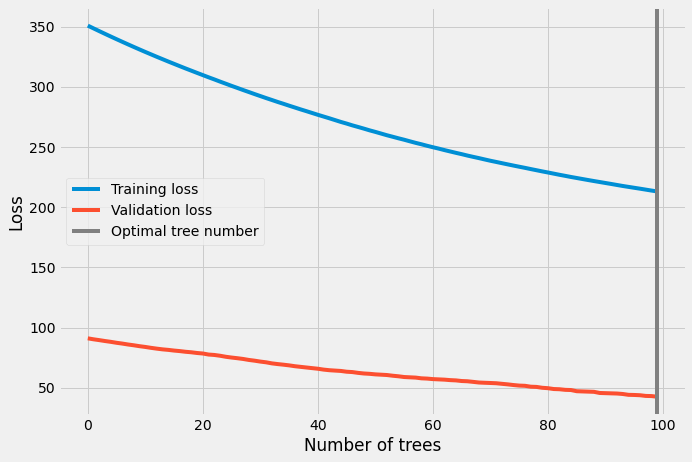

In [256]:
results = reg.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(reg.best_iteration, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

In [257]:
reg.best_iteration

99

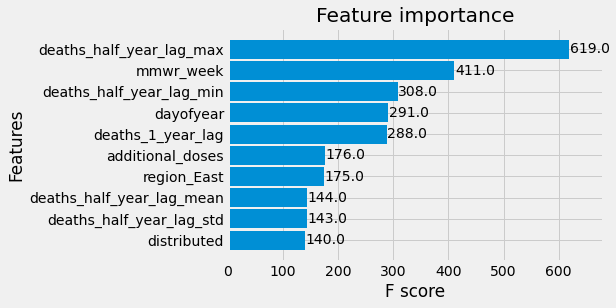

In [258]:
_ = plot_importance(reg, height=0.9 ,max_num_features = 10)

In [259]:
test['Prediction'] = reg.predict(X_test)
deaths_all = pd.concat([test, train], sort=False)
#deaths_all = deaths_all.set_index('date')

<AxesSubplot:xlabel='date'>

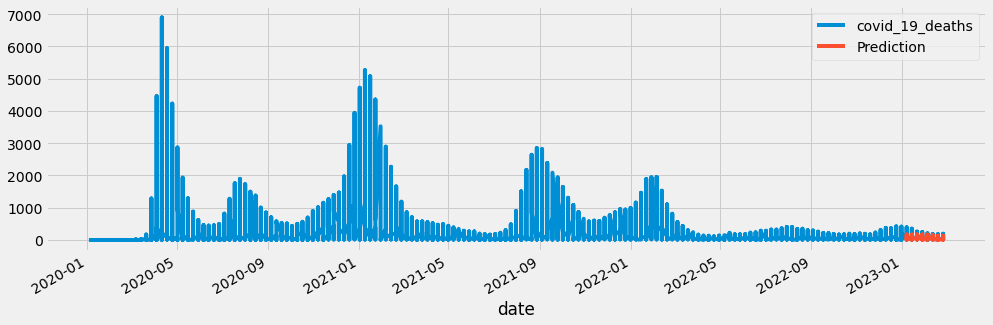

In [260]:
deaths_all.set_index('date')[['covid_19_deaths','Prediction']].plot(figsize=(15, 5))

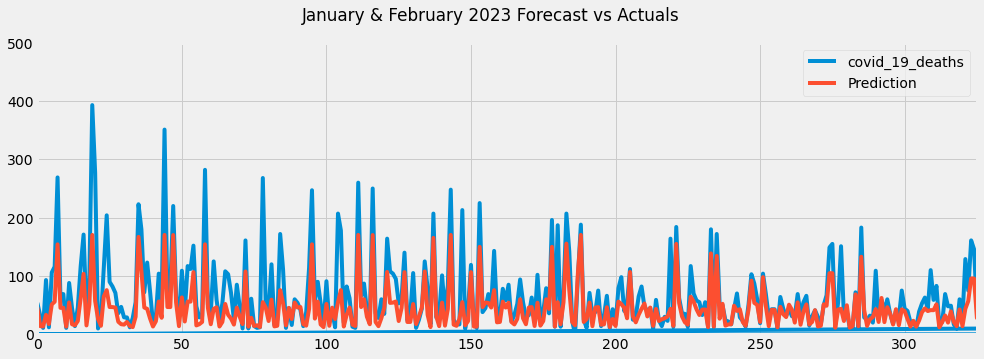

In [267]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = deaths_all[['covid_19_deaths', 'Prediction']].plot(ax=ax,
                                              style=['-','-'])
ax.set_xbound(lower=0, upper=325)
ax.set_ylim(0, 500)
plot = plt.suptitle('January & February 2023 Forecast vs Actuals')

In [235]:
model_mae = mean_absolute_error(test['covid_19_deaths'], test['Prediction'])
model_mase = MASE(test['covid_19_deaths'], test['Prediction'])

print('Test MAE: ', model_mae)
print('Test MASE: ', model_mase)

Test MAE:  16.198582923892296
Test MASE:  0.0068717657870097345


# Cross Validation

In [206]:
test.shape

(332, 142)

In [210]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits = 5)
# pjme = pjme.sort_index()

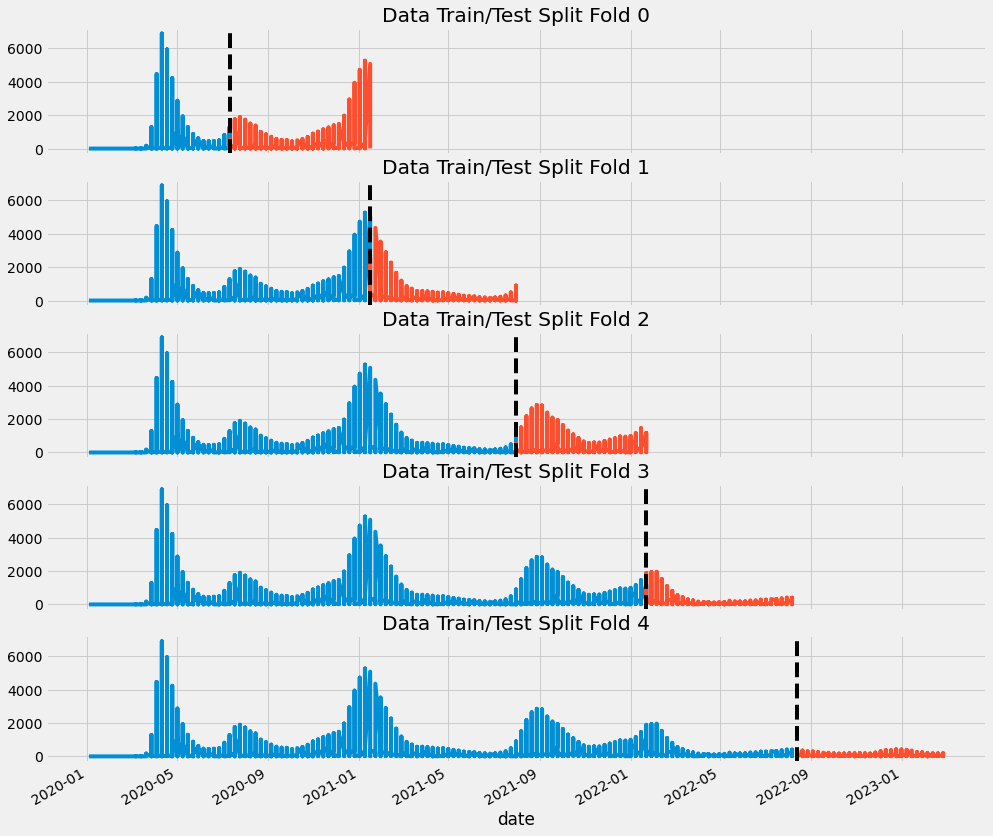

In [211]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(all_features):
    train = all_features.iloc[train_idx]
    test = all_features.iloc[val_idx]
    train['covid_19_deaths'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['covid_19_deaths'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [214]:
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(all_features):
    train = all_features.iloc[train_idx]
    test = all_features.iloc[val_idx]
    TARGET = 'covid_19_deaths'

    X_train = train.drop(['covid_19_deaths', 'location'], axis = 1)
    y_train = train[['covid_19_deaths']]

    X_test = test.drop(['covid_19_deaths', 'location'], axis = 1)
    y_test = test[['covid_19_deaths']]

    reg = XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=20,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score) 

[15:14:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:400.47755	validation_1-rmse:467.55443
[100]	validation_0-rmse:336.66564	validation_1-rmse:391.08711
[200]	validation_0-rmse:324.01186	validation_1-rmse:376.28829
[300]	validation_0-rmse:320.96680	validation_1-rmse:373.49611
[343]	validation_0-rmse:320.49973	validation_1-rmse:373.40620
[15:14:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:434.44936	validation_1-rmse:337.79082
[88]	validation_0-rmse:323.90604	validation_1-rmse:207.65069
[15:14:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regressi

In [215]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 212.3610
Fold scores:[373.150473506028, 201.39982681764528, 298.2398282287091, 153.82742850693438, 35.18744109322293]


In [218]:
# Retrain on all data
TARGET = 'covid_19_deaths'

X_all = all_features.drop(['covid_19_deaths', 'location'], axis = 1)
y_all = all_features[['covid_19_deaths']]
#X_all, y_all = create_features(pjme, TARGET)

reg = XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[15:18:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:343.81274
[100]	validation_0-rmse:239.90071
[200]	validation_0-rmse:208.28852
[300]	validation_0-rmse:196.70829
[400]	validation_0-rmse:190.52927
[499]	validation_0-rmse:186.44466


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [219]:
test['Prediction'] = reg.predict(X_test)
deaths_all = pd.concat([test, train], sort=False)

/var/folders/vw/9hmlmr_s3vq_krz6nk6qmwwh0000gn/T/ipykernel_38145/2725281835.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Prediction'] = reg.predict(X_test)


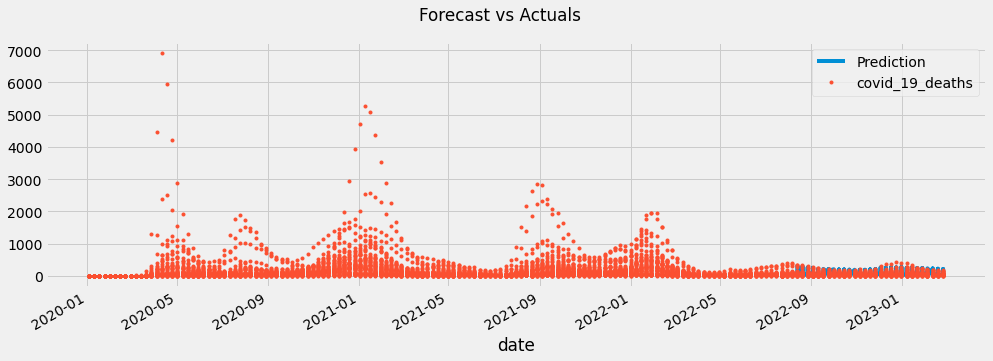

In [232]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = deaths_all[['Prediction','covid_19_deaths']].plot(ax=ax,
                                              style=['-','.'])
#ax.set_xbound(lower='2022-08-01', upper = '2023-03-01')
#ax.set_ylim(0, 1000)
plot = plt.suptitle('Forecast vs Actuals')

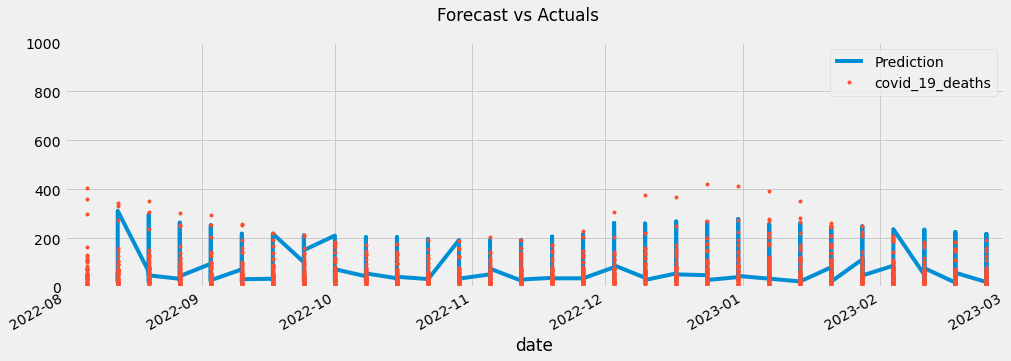

In [231]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = deaths_all[['Prediction','covid_19_deaths']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='2022-08-01', upper = '2023-03-01')
ax.set_ylim(0, 1000)
plot = plt.suptitle('Forecast vs Actuals')

In [236]:
model_mae = mean_absolute_error(test['covid_19_deaths'], test['Prediction'])
model_mase = MASE(test['covid_19_deaths'], test['Prediction'])

print('Test MAE: ', model_mae)
print('Test MASE: ', model_mase)

Test MAE:  16.198582923892296
Test MASE:  0.0068717657870097345


# Log target variable